# Energy Analytics FRI Project - Team 7

### Kushal Dandamudi, Destiny Dong, Dylan Alexander

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

#noumenclature (todo: move to readme or seperate log):
#easting  = x
#northing = y
#the bundle refers to the properties of the subsurface at x,y (not the human chosen params)
#the following conventions are used in wikipedia:
#phi is porosity
#k is permiability
#nu is Poisson's Ratio
#E is Young's Modulous
#Cw is saturation of water
#Co is saturation of oil. Co+Cw=1
#t is thickness
#pw  is proppant weight
#pr is pump rate
#ooip is Original Oil in Place
#rr is Recoverable Reserves

production_file = "well production.csv" #this stores production data and well file names

The first and most basic thing we need to do is import some of the necessary libraries. We're going to need some more later when creating our models, but these are the ones used to collect and store our data.

In [30]:
def import_production_data():
    #we import production data from a file
    df = pd.read_csv(production_file)
    oil_total = []
    #sum up the oil production for each month and add it as a column for each well
    for ind,row in df.iterrows():
        total_oil_prod = 0
        for i in range(1,  12):
            total_oil_prod += row['oil '+str(i)]
        oil_total.append(total_oil_prod)
    df['Total Oil Production'] = oil_total
    width = []
    avg_proppant_weight = []
    avg_pump_rate = []
    frac_stages = []
    start_easting = []
    start_northing = []
    total_ooip = []
    total_rr = []
    pos = 0
    for well_name in df["well name"]:
        well_df = pd.read_csv(f"{well_name}.csv")
        #also take the max-min easting and add that as a column for each well
        currWell_width = well_df['easting'][99]-well_df['easting'][0]
        width.append(currWell_width) #max easting - min easting
        start_easting.append(well_df['easting'][0])
        start_northing.append(well_df['northing'][0])
        FVF = df['formation volume factor'][pos]
        RF = df['recovery factor'][pos]
        pos+= 1
        pumpRate = 0 #for calculating avg pump rate
        proppantWeight = 0 #for calculating avg proppant rate
        numFracStages = 0 #for calculating # frac stages
        avgThickness = 0 #for calculating avg thickness
        avgPorosity = 0 #for calculating avg porosity
        avgOilSaturation = 0 #for calculating avg oil saturation
        #variables for calculating the well's OOIP
        tempThic = 0
        numPoints = 0
        prevPoint = 0
        prevPropWeight = 0
        avgFracLength = 0
        slurryVolumeMultiplier = 0.011108504
        for ind, row in well_df.iterrows():
            #if this isn't NAN, then its a frac stage
            if not np.isnan(row["proppant weight (lbs)"]):
                proppantWeight+= row["proppant weight (lbs)"]
                pumpRate+= row["pump rate (cubic feet/min)"]
                #for calculating OOIP
                if not numFracStages == 0:
                    avgFracLength+= (prevPropWeight*slurryVolumeMultiplier)/((tempThic/numPoints)*(row['easting']-prevPoint)*2)
                numPoints = 0
                tempThic = 0
                prevPoint = row['easting']
                prevPropWeight = row["proppant weight (lbs)"]
                numFracStages+= 1
            avgThickness+= row['thickness (ft)']
            avgPorosity+= row['porosity']
            avgOilSaturation+= row['oil saturation']
            #for calculating OOIP
            tempThic+= row['thickness (ft)']
            numPoints += 1
        avg_proppant_weight.append(proppantWeight/numFracStages) #divide by the numFracStages for avg
        avg_pump_rate.append(pumpRate/numFracStages) #divide by the numFracStages for avg
        frac_stages.append(numFracStages)
        #for calculating OOIP and RR
        avgFracLength/= numFracStages
        totalArea = (currWell_width*2*avgFracLength + np.pi*(avgFracLength)*(avgFracLength))/43650
        avgThickness/= 100
        avgPorosity/= 100
        avgOilSaturation/= 100
        ooip = 7758*totalArea*avgThickness*avgPorosity*avgOilSaturation/FVF
        rr = ooip* RF
        total_ooip.append(ooip)
        total_rr.append(rr)
    df['Easting'] = start_easting
    df['Northing'] = start_northing
    df['Well Width'] = width
    df['Frac Stages'] = frac_stages
    df['Avg Proppant Weight'] = avg_proppant_weight
    df['Avg Pump Rate'] = avg_pump_rate
    df['Original Oil in Place'] = total_ooip
    df['Recoverable Reserves'] = total_rr
    return df #simple!

def import_well_data(data):
    #given a file name, import well log
    r = {} #zero initial return value
    for ind,row in data.iterrows():
        well_name = row['well name']
        df = pd.read_csv(f"{well_name}.csv")
        r[well_name] = df
    return r

Now that we have our necessary libraries imported, we can start creating the methods that will build our dataframes to store the different data of our wells. The most important part of this step is to use the current parameters to calculate and store other values that can be later used. For example some of these important factors include aggregate proppant weight and pump rate, the number of frac stages, the Original Oil in Place, Recoverable Reserves, etc. 

One of the most difficult factors to get was the Original Oil in Place. This was because as a part of its formula, we were required to caluclate the area of the reservoir for each well. To do this, we used the Joshi method which looks at the drainage area as an ellipse and relates this area to the well length and half minor axis. In our case, the half minor axis is the average fracture length. To calculate this, we look at the proppant weight at each fracture and convert it to volume by using the slurry volume. From this, we can treat the volume as a rectangular box and calculate the width (which is 2 * the fracture length) by using the length between fractures and average thickness. Given this, we can compute a well's average fracture length, which we can use along with the average porosity, water saturation, and thickness along its path to calculate its Original Oil in Place and Recoverable Reserves.

In [31]:
def scatter_surface(x,y,z):
    #3d plots a points above the xy plane
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z, s=1)
    plt.show()
    
def twod_cmap_scatter(x,y,z,zString):
    #plots x,y in 2d and uses z to vary color
    im = plt.scatter(x,y, s=10, c=z)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(zString, rotation=270, labelpad=20)
    plt.show()

def build_bundle(wells):
    #we build the map of the 'world' in terms of the quantities that define it
    #our goal will be to plot and smooth this
    #this will be called once so efficiency is not a priority
    #we also rename the columns functionally
    r = pd.DataFrame(columns=["x","y","phi","k","nu","E", "Cw", "Co", "t", "pw", "pr"])
    for d in wells.values():
        r = r.append(pd.DataFrame({'x': d["easting"], 'y': d["northing"], 'phi': d["porosity"], 'k': d["permeability"], 'nu': d["Poisson's ratio"], 
            'E': d["Young's Modulus"], 'Cw': d["water saturation"], 'Co': d["oil saturation"], 't': d["thickness (ft)"],
            'pw': d["proppant weight (lbs)"], 'pr': d["pump rate (cubic feet/min)"]}))
    return r

One of the big first steps to getting started with analyzing the data is to get a good understanding of what it looks like. To do this, we create some basic methods that allows us to visually see any potential trends in our data. To do this, we both made 3d plots with the spatial data that would let us look into the parameters like porosity and permiability and how they change with space as well as 2d color maps that would essentialy do the same thing but in a more easy to interpret format such as a color map.

In [32]:
production_data = import_production_data()

#now we log production data
print("######### Production Data ##########")
pprint(production_data.head())

pprint(production_data.nlargest(10, 'Total Oil Production')) #Lets look at what some of the best producing well's parameters are

#we get the well logs by using the well names in production
wells = import_well_data(production_data)

print()
print("Bundle data head:")
bundle = build_bundle(wells)
pprint(bundle.head())

######### Production Data ##########
         well name  average pressure (Pa)  recovery factor  \
0      Peak 6-217H               35352874         0.092554   
1  Tarragon 4-119H               34882173         0.107706   
2   Fennel 10-129H               36064538         0.079150   
3  Federal 14-113H               35817881         0.103748   
4      King 7-184H               38442406         0.084675   

   formation volume factor  oil 1  oil 2  oil 3  oil 4  oil 5  oil 6  ...  \
0                      1.6  862.0  824.0  759.0  728.0  661.0  601.0  ...   
1                      1.6  228.0  249.0  214.0  210.0  161.0  163.0  ...   
2                      1.6   67.0   85.0   73.0   73.0   57.0   58.0  ...   
3                      1.6  256.0  242.0  267.0  263.0  199.0  191.0  ...   
4                      1.6   23.0   29.0   31.0   50.0   72.0   52.0  ...   

   water 12  Total Oil Production  Easting  Northing  Well Width  Frac Stages  \
0     668.0                6537.0  78000.0    

Now that we've created some methods to parse and display our data, the next step is to call them! First we need to read in the main "well production csv" file and then parse all the data from it by using the methods we previously made. Then to get a better understanding of the different parameters we're looking at and analyzing, we print the heads of the data to view them.

Plotting porosity


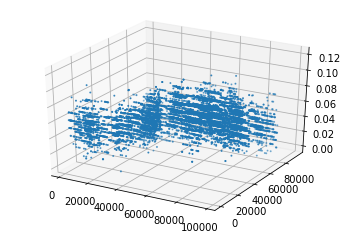

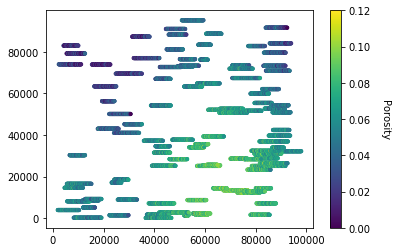

Plotting permiability


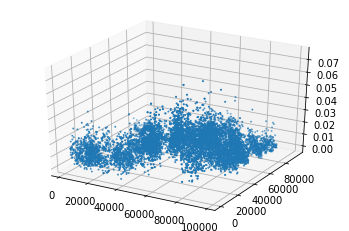

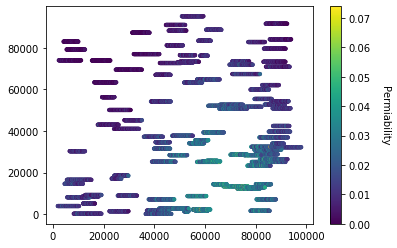

Plotting oil saturation


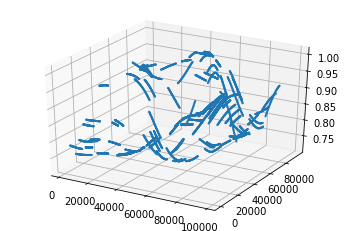

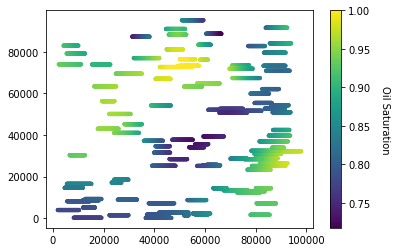

Plotting Poisson's ratio


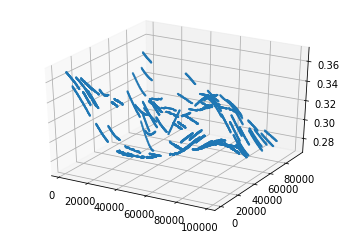

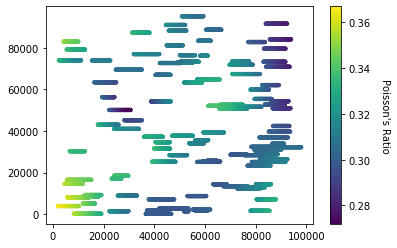

Plotting Young's Modulus


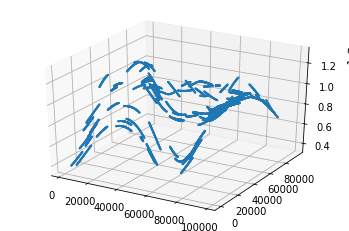

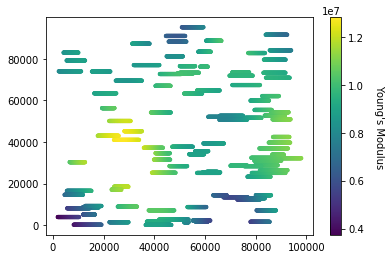

Plotting Proppant Weight


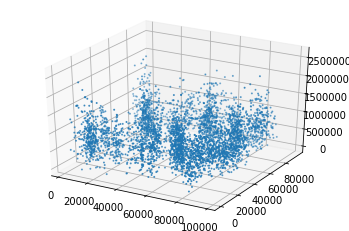

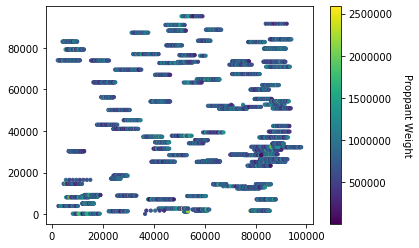

Plotting Pump Rate


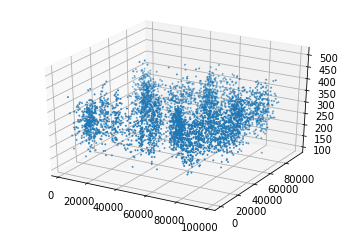

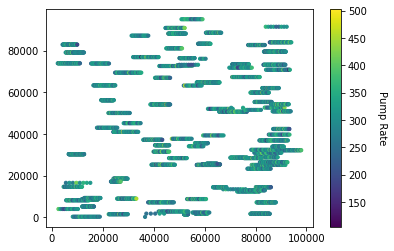

Plotting Total Oil Production vs Location


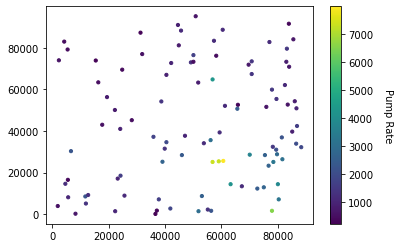

Plotting Total Oil Production vs. Well Width


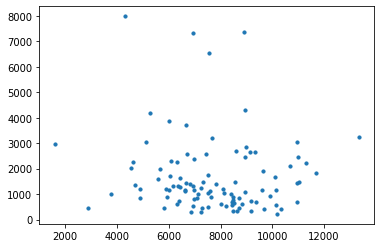

Plotting Total Oil Production vs. # Frac Stages


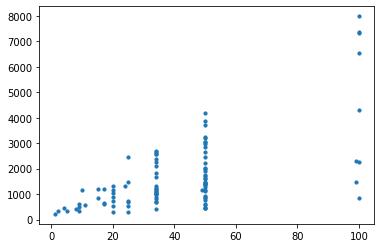

Plotting Total Oil Production vs. Avg Proppant Weight


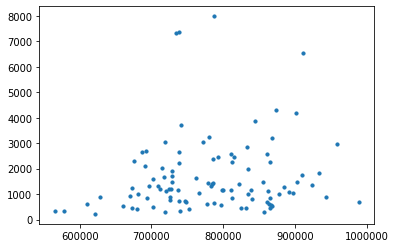

Plotting Total Oil Production vs. Avg Pump Rate


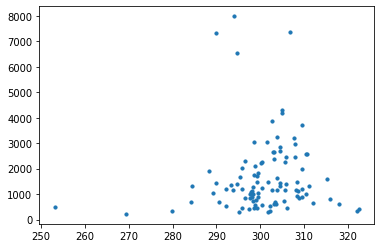

In [5]:
#we now graph x,y vs porosity for visualisation to locate trends in the data
print("Plotting porosity")
scatter_surface(bundle["x"], bundle["y"], bundle["phi"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["phi"], "Porosity")
#for instance phi seems to be increasing with x and decreasing with y. the data looks roughly linear.
print("Plotting permiability")
scatter_surface(bundle["x"], bundle["y"], bundle["k"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["k"], "Permiability")
print("Plotting oil saturation")
scatter_surface(bundle["x"], bundle["y"], bundle["Co"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["Co"], "Oil Saturation")
print("Plotting Poisson's ratio")
scatter_surface(bundle["x"], bundle["y"], bundle["nu"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["nu"], "Poisson's Ratio")
print("Plotting Young's Modulus")
scatter_surface(bundle["x"], bundle["y"], bundle["E"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["E"], "Young's Modulus")
print("Plotting Proppant Weight")
scatter_surface(bundle["x"], bundle["y"], bundle["pw"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["pw"], "Proppant Weight")
print("Plotting Pump Rate")
scatter_surface(bundle["x"], bundle["y"], bundle["pr"])
twod_cmap_scatter(bundle["x"], bundle["y"], bundle["pr"], "Pump Rate")
#We don't need to plot water saturation AND oil saturation because they are just complements of each other 
#print("Plotting water saturation")
#scatter_surface(bundle["x"], bundle["y"], bundle["Cw"])
#twod_cmap_scatter(bundle["x"], bundle["y"], bundle["Cw"], "Water Saturation")
#print("Plotting thickness")
#scatter_surface(bundle["x"], bundle["y"], bundle["t"])

#plot total oil production vs location as a color map
print("Plotting Total Oil Production vs Location")
twod_cmap_scatter(production_data['Easting'], production_data['Northing'], production_data['Total Oil Production'], "Pump Rate")

#plot total oil production vs well width
print("Plotting Total Oil Production vs. Well Width")
im = plt.scatter(production_data['Well Width'], production_data['Total Oil Production'], s=10)
plt.show()

#plot total oil production vs # frac stages
print("Plotting Total Oil Production vs. # Frac Stages")
im = plt.scatter(production_data['Frac Stages'], production_data['Total Oil Production'], s=10)
plt.show()

#plot total oil production vs avg proppant weight
print("Plotting Total Oil Production vs. Avg Proppant Weight")
im = plt.scatter(production_data['Avg Proppant Weight'], production_data['Total Oil Production'], s=10)
plt.show()

#plot total oil production vs avg pump rate
print("Plotting Total Oil Production vs. Avg Pump Rate")
im = plt.scatter(production_data['Avg Pump Rate'], production_data['Total Oil Production'], s=10)
plt.show()

In this step we used all the methods we previously made as well as some new plots to graph the data in different forms. As mentioned before this was mostly either some 2d color maps or 3d view of how different factors varied with location. The most useful part of these plots aside from gaining an understanding of the data would be in narrowing down our domain to use in searching for the most optimal values for our parameters to produce the most output. For example, for the well width we could easily see that its very likely that total oil production is maximized at some distance between 4,000 and 11,000 which helps to narrow down the values we must search through.

Now that we have all of our data parsed from the files we are given and also have a decent understanding of what it looks like through the plots and the head() calls, the next step is to start trying to build a model that can properly work.

In [6]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = production_data[['Avg Proppant Weight', 'Easting', 'Northing', 'Well Width', 'Frac Stages',  'Avg Pump Rate']]
y = production_data['Total Oil Production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=0)

The first step to take in building these models is to split our data into the X parameters to be used for predicting a certain y parameter. In this case, we are using the parameters that can be seen above, (avg proppant weight, easting, northing,  well width, frac stages, avg pump rate) to predict total oil production which is simply an aggregate over the 12 months. After that, we need to split our data into training and testing sets which can easily be done as seen above.

In [7]:
clf = linear_model.Lasso()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print("The score for our LASSO Regression model is " + str(score))

The score for our LASSO Regression model is 0.7440702921222799


The first model we're going to try using is a LASSO regression or L1 feature selection model. After doing this, we see that the model is alright with a score around 75%, but there is definetly room for improvement. 

In [8]:
clf = linear_model.Ridge()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print("The score for our Ridge Regression model is " + str(score))

The score for our Ridge Regression model is 0.7440872341097609


After trying out L1 feature selection, we're going to try and use a Ridge Regression model or L2 feature selection. We understand that this model should perform very similarly to the previous one, but we just wanted to try it out and see how it works. After creating this model, we can see as expected that it performs very similarly to the LASSO regression model, so although it is decent it can definetly be greatly improved.

In [9]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
score = clf.score(X_test,  y_test)

print("The score for our decision tree model is " + str(score))

#export so we can visualize what is going on
# dot_data = tree.export_graphviz(clf, out_file='reggraph', feature_names=X.columns, filled=True)

The score for our decision tree model is 0.9015826151795744


The next model we want to try and apply to our data is a decision tree. After creating a model for our data using this, we can see that our results are already much better than the previous models with scores of around 0.9. However, this model is quite random and varies from run to run, so we want to see if we can make a more stable model.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(random_state=0, n_estimators=300)
regr.fit(X_train, y_train)
score = regr.score(X_test, y_test)

print("The score for our Random Forest model is " + str(score))
print(regr.feature_importances_)
print(regr.predict([[1000000, 65000, 15000, 4000, 80, 305]]))

The score for our Random Forest model is 0.9078808396228322
[0.05417935 0.17006355 0.2186674  0.06001772 0.4645424  0.03252958]
[4332.12]


In order to stabilize our decision trees, we could use Random Forests! Essentially, this would use a multitude of decisision trees to improve our model. After creating such a model, we now have a fairly accurate AND stable model with a score of 0.908. We also print the feature_importances_ parameter for this model to see how important each of our input parameters are in determining the oil production.

In [11]:
# inputs for prediction
x_preds = {}
well_prop = []
for i in range(760000, 770001, 1000):
    well_prop.append(i)
count = 1
for x in range(60000, 80001, 5000):
    for y in range(16000, 32001, 2000):
        for k in range(4000, 8001, 1000):
            valid_well = True
            for ind, row in production_data.iterrows():
                #check if it overlaps with any previously made well
                if y == row['Northing'] and (x <= row['Easting'] and x+k >= row['Easting'] or 
                                             x >= row['Easting'] and x-row['Well Width'] <= row['Easting']):
                    valid_well = False
            if valid_well:
                for i in range (100, 101, 20): #we know # frac stages should be 100 from many trial and error
                    for j in range(285, 288):
                        name = "df" + str(count)
                        count = count+1
                        x_preds[name] = pd.DataFrame(well_prop, columns =['prop'])
                        x_preds[name]['x'] = x
                        x_preds[name]['y'] = y
                        x_preds[name]['width'] = k
                        x_preds[name]['frac'] = i
                        x_preds[name]['pump'] = j
                        res = regr.predict(x_preds[name])
                        x_preds[name]['oil production'] = res
                        x_preds[name] = x_preds[name].nlargest(1, 'oil production')

In order to find the most optimal X parameters to maximize output, we must create a domain that we can predict the total oil production for and find where it's the highest. To do this, we use a step size and boundaries for each parameter that we base off of the plots we previously did that suggest where the production would likely be the highest. In doing this, there involved a lot of trial and error in modifying the parameters. To do this, we would change the step sizes and domain for each parameter at a time, shortening it to make our trials much faster. In addition to this, after we select our (easting, northing) and width, we need to make sure that this new well we could potentially add doesn't overlap with any other prexisting well, so we added a check for this in creating our domain.

In [12]:
predictions = x_preds['df1']
for i in range(2,count):
    name = "df" + str(i)
    predictions = pd.concat([predictions, x_preds[name]])
# print top 10 predictions
searchPred = predictions.nlargest(200, 'oil production')
visited = []
nextWells = pd.DataFrame()
pos = 0
for ind, row in searchPred.iterrows():
    #Make sure that this well doesn't overlap with any previously chosen well to use as our next 10
    valid_well = True
    for currPos in visited:
        if row['y'] == currPos[1] and (row['x'] <= currPos[0] and row['x']+row['width'] >= currPos[0] or
                                         row['x'] >= currPos[0] and row['x']-currPos[2] <= currPos[0]):
                    valid_well = False
    if valid_well and len(visited) < 10:
        visited.append([row['x'],  row['y'], row['width']])
        nextWells[pos] = row
        pos+= 1
        
print(nextWells.transpose())

       prop        x        y   width   frac   pump  oil production
0  763000.0  60000.0  28000.0  4000.0  100.0  287.0     6968.243333
1  763000.0  65000.0  28000.0  4000.0  100.0  287.0     6968.243333
2  763000.0  60000.0  26000.0  4000.0  100.0  287.0     6967.236667
3  763000.0  65000.0  26000.0  4000.0  100.0  287.0     6967.236667
4  763000.0  60000.0  30000.0  4000.0  100.0  287.0     6952.276667
5  763000.0  65000.0  30000.0  4000.0  100.0  287.0     6952.276667
6  763000.0  60000.0  22000.0  4000.0  100.0  287.0     6910.536667
7  763000.0  60000.0  24000.0  4000.0  100.0  287.0     6910.536667
8  763000.0  65000.0  22000.0  4000.0  100.0  287.0     6910.536667
9  763000.0  65000.0  24000.0  4000.0  100.0  287.0     6910.536667


Now that we have the most optimal values for our wells, we want to choose the 10 best ones. In doing this, we also must make sure that we don't choose two wells that overlap, so when picking each well, we need to go through all of our future well predictions we have already chosen and make sure that this potential new well doesn't overlap with any of these.

In [33]:
spatialX = production_data[['Easting', 'Northing', 'Well Width']]
ooipY = production_data['Original Oil in Place']
rrY = production_data['Recoverable Reserves']

ooipX_train, ooipX_test, ooipY_train, ooipY_test = train_test_split(spatialX, ooipY, test_size= 0.1, random_state=0)
rrX_train, rrX_test, rrY_train, rrY_test = train_test_split(spatialX, rrY, test_size= 0.1, random_state=0)

regrOOIP = RandomForestRegressor(random_state=0, n_estimators=100)
regrOOIP.fit(ooipX_train, ooipY_train)
score = regrOOIP.score(ooipX_test, ooipY_test)

print('The score for predicting Original Oil in Place is ' + str(score))
print(regrOOIP.feature_importances_)


regrRR = RandomForestRegressor(random_state=0, n_estimators=100)
regrRR.fit(rrX_train, rrY_train)
score = regrRR.score(rrX_test, rrY_test)

print('The score for predicting Recoverable Reserves is ' + str(score))
print(regrRR.feature_importances_)

The score for predicting Original Oil in Place is -0.011258945304470693
[0.25648302 0.51650332 0.22701366]
The score for predicting Recoverable Reserves is -0.2308391999874102
[0.23110626 0.54194342 0.22695032]


Because Original Oil in Place is dependent on spatial parameters such as porosity and oil/water saturation, and Recoverable Reserves is similarly related, we can just predict these parameters based on the (easting, northing) starting location and length of a well by using a random forest like we did for our previous model. As we can see, this model is also very good, and is usable for us in predicting these values for our new wells. We once again print the feature_importances_ for each model to get a better understanding of how it works.

In [19]:
#Use the models made above to predict OOIP and RR at the 10 locations of our next wells

summedOOIP = 0
summedRR = 0
summedEUR = 0
finalPredictions = pd.DataFrame()
pos = 1

for ind in nextWells:
    well = nextWells[ind]
    OOIP = regrOOIP.predict([[well['x'], well['y'], well['width']]])[0]
    RR = regrRR.predict([[ well['x'], well['y'], well['width']]])[0]
    well['OOIP'] = OOIP
    well['RR'] = RR
    finalPredictions["Well " + str(pos)] = well
    pos+= 1
    summedOOIP+= OOIP
    summedRR+= RR
    summedEUR+= well['oil production']
    
finalPredictions = finalPredictions.transpose()
print(finalPredictions)

             prop        x        y   width   frac   pump  oil production  \
Well 1   763000.0  60000.0  28000.0  4000.0  100.0  287.0     6968.243333   
Well 2   763000.0  65000.0  28000.0  4000.0  100.0  287.0     6968.243333   
Well 3   763000.0  60000.0  26000.0  4000.0  100.0  287.0     6967.236667   
Well 4   763000.0  65000.0  26000.0  4000.0  100.0  287.0     6967.236667   
Well 5   763000.0  60000.0  30000.0  4000.0  100.0  287.0     6952.276667   
Well 6   763000.0  65000.0  30000.0  4000.0  100.0  287.0     6952.276667   
Well 7   763000.0  60000.0  22000.0  4000.0  100.0  287.0     6910.536667   
Well 8   763000.0  60000.0  24000.0  4000.0  100.0  287.0     6910.536667   
Well 9   763000.0  65000.0  22000.0  4000.0  100.0  287.0     6910.536667   
Well 10  763000.0  65000.0  24000.0  4000.0  100.0  287.0     6910.536667   

                OOIP          RR  
Well 1   4474.299408  432.562276  
Well 2   4259.730556  406.362436  
Well 3   5024.615091  475.598785  
Well 4   469

We can now apply the model we previously made to predict the Original Oil in Place and Recoverable Reserves value for a well given its easting, northing, and length. After doing this, we now have all the desired values and properties for the next 10 wells we suggest to build.

In [15]:
print("The total summed Original Oil in Place is " + str(summedOOIP))
print("The total summed Recoverable Reserves is " + str(summedRR))
print("The total Estimated Ultimate Recovery is " + str(summedEUR))

The total summed Original Oil in Place is 45202.68408715915
The total summed Recoverable Reserves is 4345.043553535712
The total Estimated Ultimate Recovery is 69417.66


Finally, we can also look at an aggreegate of the Original Oil in Place, Recoverable Reserves, annd Estimated Ultimate Recovery for the next 10 well predictions we've made.